Section 3 

1. Data Understanding & Cleaning 

In [1]:

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display & style
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

# Load dataset (relative path for VS Code project structure)
df = pd.read_csv("../data/AB_NYC_2019.csv")

# Preview dataset
df.head()


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [2]:
# Dataset dimensions
print("Rows, Columns:", df.shape)

# Data types & non-null counts
df.info()


Rows, Columns: (48895, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_

In [3]:
# Missing value overview
df.isnull().sum()


id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [4]:
# Check duplicate rows
print("Duplicate rows:", df.duplicated().sum())

# Remove duplicates
df = df.drop_duplicates()

print("Shape after deduplication:", df.shape)


Duplicate rows: 0
Shape after deduplication: (48895, 16)


In [5]:
# Fill missing reviews with 0 (no popularity)
df["number_of_reviews"] = df["number_of_reviews"].fillna(0)

# Fill reviews per month with 0
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)

# Drop rows missing critical fields
df = df.dropna(subset=["price", "neighbourhood", "neighbourhood_group"])

# Final missing value check
df.isnull().sum()


id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                     0
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [6]:
avg_price_borough = (
    df.groupby("neighbourhood_group")["price"]
    .mean()
    .sort_values(ascending=False)
)

avg_price_borough


neighbourhood_group
Manhattan        196.875814
Brooklyn         124.383207
Staten Island    114.812332
Queens            99.517649
Bronx             87.496792
Name: price, dtype: float64

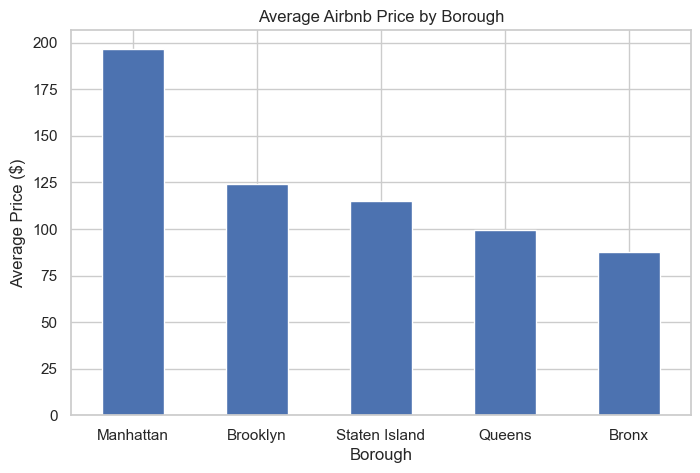

In [7]:
plt.figure(figsize=(8,5))
avg_price_borough.plot(kind="bar")
plt.title("Average Airbnb Price by Borough")
plt.ylabel("Average Price ($)")
plt.xlabel("Borough")
plt.xticks(rotation=0)
plt.show()


In [8]:
room_type_share = df["room_type"].value_counts(normalize=True) * 100
room_type_share


room_type
Entire home/apt    51.966459
Private room       45.661111
Shared room         2.372431
Name: proportion, dtype: float64

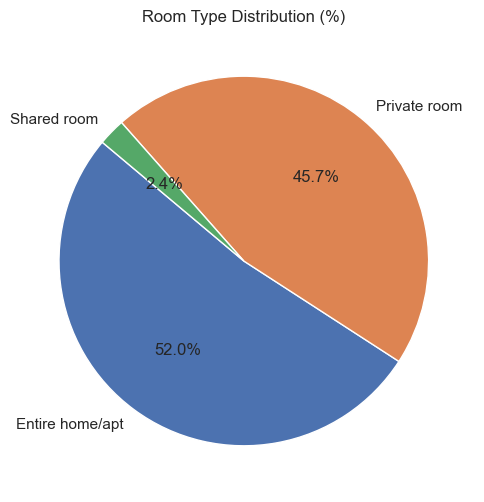

In [9]:
plt.figure(figsize=(6,6))
room_type_share.plot(kind="pie", autopct="%1.1f%%", startangle=140)
plt.title("Room Type Distribution (%)")
plt.ylabel("")
plt.show()


In [10]:
# Descriptive statistics
df["availability_365"].describe()


count    48895.000000
mean       112.781327
std        131.622289
min          0.000000
25%          0.000000
50%         45.000000
75%        227.000000
max        365.000000
Name: availability_365, dtype: float64

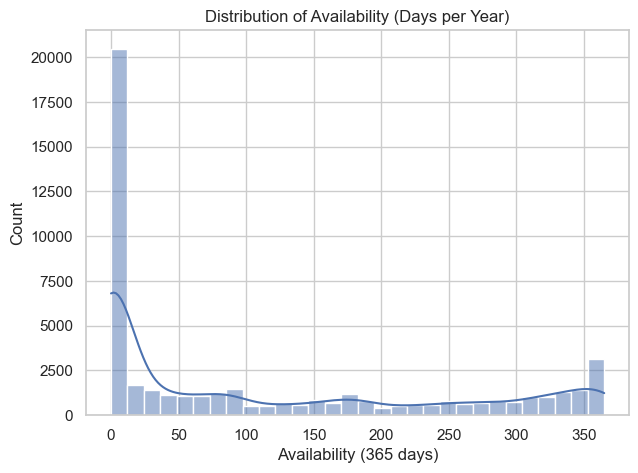

In [11]:
plt.figure(figsize=(7,5))
sns.histplot(df["availability_365"], bins=30, kde=True)
plt.title("Distribution of Availability (Days per Year)")
plt.xlabel("Availability (365 days)")
plt.show()


2. Feature Engineering 


In [12]:
# Popularity proxy 1: raw review count
df["reviews_per_listing"] = df["number_of_reviews"]

# Popularity proxy 2: reviews adjusted by availability
# +1 avoids division by zero
df["reviews_per_availability"] = df["number_of_reviews"] / (df["availability_365"] + 1)

df[["reviews_per_listing", "reviews_per_availability"]].head()


,reviews_per_listing,reviews_per_availability
0,9,0.024590
1,45,0.126404
2,0,0.000000
3,270,1.384615
4,9,9.000000


In [13]:
neighbourhood_features = (
    df.groupby(["neighbourhood_group", "neighbourhood"])
    .agg(
        avg_price=("price", "mean"),
        avg_availability=("availability_365", "mean"),
        avg_reviews=("number_of_reviews", "mean"),
        popularity_score=("reviews_per_availability", "mean"),
        listing_count=("id", "count")
    )
    .reset_index()
)

neighbourhood_features.head()


,neighbourhood_group,neighbourhood,avg_price,avg_availability,avg_reviews,popularity_score,listing_count
0,Bronx,Allerton,87.595238,163.666667,42.928571,1.534377,42
1,Bronx,Baychester,75.428571,157.857143,44.285714,0.330753,7
2,Bronx,Belmont,77.125000,187.666667,12.333333,0.966259,24
3,Bronx,Bronxdale,57.105263,145.421053,24.105263,7.602273,19
4,Bronx,Castle Hill,63.000000,159.333333,13.111111,0.138243,9


In [14]:
# Log transformation to stabilize skewed distributions
neighbourhood_features["log_avg_price"] = np.log1p(neighbourhood_features["avg_price"])
neighbourhood_features["log_popularity"] = np.log1p(neighbourhood_features["popularity_score"])


In [15]:
# Check missing values
neighbourhood_features.isnull().sum()


neighbourhood_group    0
neighbourhood          0
avg_price              0
avg_availability       0
avg_reviews            0
popularity_score       0
listing_count          0
log_avg_price          0
log_popularity         0
dtype: int64

In [16]:
# Summary statistics
neighbourhood_features.describe()


,avg_price,avg_availability,avg_reviews,popularity_score,listing_count,log_avg_price,log_popularity
count,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000
mean,133.248493,152.497773,23.860117,2.457267,221.244344,4.756299,0.969895
std,94.530766,62.444847,14.921102,3.812874,536.160961,0.488666,0.686601
min,47.333333,0.000000,0.000000,0.000000,1.000000,3.878121,0.000000
25%,81.730769,106.577502,15.076389,0.373988,10.000000,4.415592,0.317718
50%,101.800000,150.279570,21.693252,1.669565,32.000000,4.632785,0.981916
75%,152.714286,189.400000,29.259740,3.450443,154.000000,5.035096,1.493004
max,800.000000,365.000000,118.500000,45.226154,3920.000000,6.685861,3.833546


In [17]:
# Most expensive neighbourhoods
neighbourhood_features.sort_values("avg_price", ascending=False).head(10)


,neighbourhood_group,neighbourhood,avg_price,avg_availability,avg_reviews,popularity_score,listing_count,log_avg_price,log_popularity
188,Staten Island,Fort Wadsworth,800.000000,365.000000,0.000000,0.000000,1,6.685861,0.000000
220,Staten Island,Woodrow,700.000000,0.000000,0.000000,0.000000,1,6.552508,0.000000
121,Manhattan,Tribeca,490.638418,126.508475,11.491525,1.669565,177,6.197744,0.981916
88,Brooklyn,Sea Gate,487.857143,65.571429,1.428571,0.432645,7,6.192070,0.359522
34,Bronx,Riverdale,442.090909,160.818182,26.636364,18.849816,11,6.093775,2.988195
204,Staten Island,Prince's Bay,409.500000,110.500000,5.750000,3.779851,4,6.017376,1.564409
95,Manhattan,Battery Park City,367.557143,100.328571,8.285714,2.867891,70,5.909596,1.352709
102,Manhattan,Flatiron District,341.925000,123.050000,17.737500,1.521109,80,5.837512,0.924699
205,Staten Island,Randall Manor,336.000000,275.210526,18.000000,0.155373,19,5.820083,0.144423
115,Manhattan,NoHo,295.717949,101.820513,12.743590,1.745170,78,5.692782,1.009843


In [18]:
# Most popular neighbourhoods
neighbourhood_features.sort_values("popularity_score", ascending=False).head(10)


,neighbourhood_group,neighbourhood,avg_price,avg_availability,avg_reviews,popularity_score,listing_count,log_avg_price,log_popularity
210,Staten Island,Silver Lake,70.000000,162.000000,118.500000,45.226154,2,4.262680,3.833546
34,Bronx,Riverdale,442.090909,160.818182,26.636364,18.849816,11,6.093775,2.988195
167,Queens,Richmond Hill,87.117021,194.936170,34.361702,13.137919,94,4.478666,2.648861
201,Staten Island,New Springville,76.000000,65.250000,29.375000,11.272983,8,4.343805,2.507400
181,Staten Island,Bull's Head,47.333333,165.666667,15.333333,10.513315,6,3.878121,2.443504
83,Brooklyn,Navy Yard,151.642857,48.928571,17.928571,9.836217,14,5.028101,2.382894
172,Queens,Springfield Gardens,94.235294,204.011765,69.094118,9.256014,85,4.556351,2.327864
185,Staten Island,Dongan Hills,79.428571,157.285714,22.571429,9.135796,7,4.387369,2.316073
3,Bronx,Bronxdale,57.105263,145.421053,24.105263,7.602273,19,4.062256,2.152026
209,Staten Island,Shore Acres,152.714286,114.571429,20.857143,7.335109,7,5.035096,2.120477


3. Value Score

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

neighbourhood_features[[
    "price_norm",
    "availability_norm",
    "popularity_norm"
]] = scaler.fit_transform(
    neighbourhood_features[[
        "avg_price",
        "avg_availability",
        "popularity_score"
    ]]
)

neighbourhood_features.head()


,neighbourhood_group,neighbourhood,avg_price,avg_availability,avg_reviews,popularity_score,listing_count,log_avg_price,log_popularity,price_norm,availability_norm,popularity_norm
0,Bronx,Allerton,87.595238,163.666667,42.928571,1.534377,42,4.484078,0.929948,0.053492,0.448402,0.033927
1,Bronx,Baychester,75.428571,157.857143,44.285714,0.330753,7,4.336357,0.285745,0.037328,0.432485,0.007313
2,Bronx,Belmont,77.125000,187.666667,12.333333,0.966259,24,4.358310,0.676133,0.039581,0.514155,0.021365
3,Bronx,Bronxdale,57.105263,145.421053,24.105263,7.602273,19,4.062256,2.152026,0.012983,0.398414,0.168095
4,Bronx,Castle Hill,63.000000,159.333333,13.111111,0.138243,9,4.158883,0.129486,0.020815,0.436530,0.003057


In [33]:
neighbourhood_features["value_score"] = (
    neighbourhood_features["availability_norm"] *
    neighbourhood_features["popularity_norm"]
) / (neighbourhood_features["price_norm"] + 0.1)



In [34]:
neighbourhood_features[[
    "neighbourhood_group",
    "neighbourhood",
    "value_score"
]].sort_values("value_score", ascending=False).head(10)


,neighbourhood_group,neighbourhood,value_score
210,Staten Island,Silver Lake,3.411099
181,Staten Island,Bull's Head,1.055097
167,Queens,Richmond Hill,1.014965
172,Queens,Springfield Gardens,0.704758
185,Staten Island,Dongan Hills,0.610247
3,Bronx,Bronxdale,0.592754
171,Queens,South Ozone Park,0.586361
158,Queens,Laurelton,0.492623
215,Staten Island,Tompkinsville,0.461247
57,Brooklyn,Brownsville,0.333672


In [23]:
neighbourhood_features[[
    "neighbourhood_group",
    "neighbourhood",
    "value_score"
]].sort_values("value_score").head(10)


,neighbourhood_group,neighbourhood,value_score
199,Staten Island,New Dorp,0.000000
220,Staten Island,Woodrow,0.000000
188,Staten Island,Fort Wadsworth,0.000000
180,Staten Island,"Bay Terrace, Staten Island",0.000000
134,Queens,Breezy Point,0.000381
219,Staten Island,Willowbrook,0.002029
132,Queens,Belle Harbor,0.002117
44,Bronx,West Farms,0.002204
150,Queens,Holliswood,0.002250
88,Brooklyn,Sea Gate,0.002936


In [35]:
high_threshold = neighbourhood_features["value_score"].quantile(0.75)
low_threshold = neighbourhood_features["value_score"].quantile(0.25)

def classify_value(score):
    if score >= high_threshold:
        return "Undervalued"
    elif score <= low_threshold:
        return "Overpriced"
    else:
        return "Fairly Priced"

neighbourhood_features["value_category"] = neighbourhood_features["value_score"].apply(classify_value)

neighbourhood_features["value_category"].value_counts()


value_category
Fairly Priced    109
Undervalued       56
Overpriced        56
Name: count, dtype: int64

In [36]:

neighbourhood_features_sorted = neighbourhood_features.sort_values(
    "value_score", ascending=False
)

neighbourhood_features_sorted.head()


,neighbourhood_group,neighbourhood,avg_price,avg_availability,avg_reviews,popularity_score,listing_count,log_avg_price,log_popularity,price_norm,availability_norm,popularity_norm,value_score,value_category,value_rank,justification
210,Staten Island,Silver Lake,70.000000,162.000000,118.500000,45.226154,2,4.262680,3.833546,0.030115,0.443836,1.000000,3.411099,Undervalued,2.0,"lower-than-average price, strong demand"
181,Staten Island,Bull's Head,47.333333,165.666667,15.333333,10.513315,6,3.878121,2.443504,0.000000,0.453881,0.232461,1.055097,Undervalued,1.0,"lower-than-average price, strong demand"
167,Queens,Richmond Hill,87.117021,194.936170,34.361702,13.137919,94,4.478666,2.648861,0.052857,0.534072,0.290494,1.014965,Undervalued,5.0,"lower-than-average price, higher availability,..."
172,Queens,Springfield Gardens,94.235294,204.011765,69.094118,9.256014,85,4.556351,2.327864,0.062314,0.558936,0.204661,0.704758,Undervalued,8.0,"lower-than-average price, higher availability,..."
185,Staten Island,Dongan Hills,79.428571,157.285714,22.571429,9.135796,7,4.387369,2.316073,0.042642,0.430920,0.202002,0.610247,Undervalued,6.0,"lower-than-average price, strong demand"


In [47]:
# ---------------------------------------
# FILTER: Remove neighbourhoods with very few listings
# ---------------------------------------

min_listings = 30

filtered_features = neighbourhood_features[
    neighbourhood_features["listing_count"] >= min_listings
].copy()

print("Before filtering:", neighbourhood_features.shape)
print("After filtering:", filtered_features.shape)


Before filtering: (221, 16)
After filtering: (115, 16)


In [48]:
filtered_features.sort_values("value_score", ascending=False)


,neighbourhood_group,neighbourhood,avg_price,avg_availability,avg_reviews,popularity_score,listing_count,log_avg_price,log_popularity,price_norm,availability_norm,popularity_norm,value_score,value_category,value_rank,justification
167,Queens,Richmond Hill,87.117021,194.936170,34.361702,13.137919,94,4.478666,2.648861,0.052857,0.534072,0.290494,1.014965,Undervalued,3.0,"lower-than-average price, higher availability,..."
172,Queens,Springfield Gardens,94.235294,204.011765,69.094118,9.256014,85,4.556351,2.327864,0.062314,0.558936,0.204661,0.704758,Undervalued,4.0,"lower-than-average price, higher availability,..."
171,Queens,South Ozone Park,82.400000,226.100000,48.675000,6.275536,40,4.423648,1.984518,0.046590,0.619452,0.138759,0.586361,Undervalued,7.0,"lower-than-average price, higher availability,..."
215,Staten Island,Tompkinsville,76.190476,209.428571,57.142857,5.029533,42,4.346276,1.796670,0.038340,0.573777,0.111209,0.461247,Undervalued,9.0,"lower-than-average price, higher availability,..."
57,Brooklyn,Brownsville,76.459016,121.327869,31.344262,6.296626,61,4.349749,1.987412,0.038697,0.332405,0.139225,0.333672,Undervalued,10.0,"lower-than-average price, higher availability,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Manhattan,NoHo,295.717949,101.820513,12.743590,1.745170,78,5.692782,1.009843,0.330006,0.278960,0.038588,0.025033,Fairly Priced,159.0,
102,Manhattan,Flatiron District,341.925000,123.050000,17.737500,1.521109,80,5.837512,0.924699,0.391397,0.337123,0.033633,0.023074,Fairly Priced,163.0,higher availability
55,Brooklyn,Brighton Beach,131.933333,170.866667,17.960000,0.404636,75,4.889848,0.339778,0.112400,0.468128,0.008947,0.019719,Overpriced,171.0,"lower-than-average price, higher availability"
121,Manhattan,Tribeca,490.638418,126.508475,11.491525,1.669565,177,6.197744,0.981916,0.588979,0.346599,0.036916,0.018571,Overpriced,174.0,higher availability


4.  Benchmark & Ranking

In [52]:
filtered_features["value_rank"] = (
    filtered_features["value_score"]
    .rank(ascending=False, method="dense")
)

filtered_features.sort_values("value_rank").head(10)


,neighbourhood_group,neighbourhood,avg_price,avg_availability,avg_reviews,popularity_score,listing_count,log_avg_price,log_popularity,price_norm,availability_norm,popularity_norm,value_score,value_category,value_rank,justification
167,Queens,Richmond Hill,87.117021,194.936170,34.361702,13.137919,94,4.478666,2.648861,0.052857,0.534072,0.290494,1.014965,Undervalued,1.0,"lower-than-average price, higher availability,..."
172,Queens,Springfield Gardens,94.235294,204.011765,69.094118,9.256014,85,4.556351,2.327864,0.062314,0.558936,0.204661,0.704758,Undervalued,2.0,"lower-than-average price, higher availability,..."
171,Queens,South Ozone Park,82.400000,226.100000,48.675000,6.275536,40,4.423648,1.984518,0.046590,0.619452,0.138759,0.586361,Undervalued,3.0,"lower-than-average price, higher availability,..."
215,Staten Island,Tompkinsville,76.190476,209.428571,57.142857,5.029533,42,4.346276,1.796670,0.038340,0.573777,0.111209,0.461247,Undervalued,4.0,"lower-than-average price, higher availability,..."
57,Brooklyn,Brownsville,76.459016,121.327869,31.344262,6.296626,61,4.349749,1.987412,0.038697,0.332405,0.139225,0.333672,Undervalued,5.0,"lower-than-average price, higher availability,..."
33,Bronx,Port Morris,79.891304,152.173913,20.608696,4.797804,46,4.393106,1.757479,0.043257,0.416915,0.106085,0.308734,Undervalued,6.0,"lower-than-average price, strong demand"
19,Bronx,Longwood,91.919355,154.225806,26.661290,4.916070,62,4.531732,1.777672,0.059237,0.422536,0.108700,0.288435,Undervalued,7.0,"lower-than-average price, strong demand"
170,Queens,Rosedale,76.694915,177.949153,28.355932,3.640099,59,4.352790,1.534736,0.039010,0.487532,0.080487,0.282280,Undervalued,8.0,"lower-than-average price, higher availability,..."
141,Queens,East Elmhurst,81.183784,169.491892,81.659459,3.748868,185,4.408958,1.557906,0.044974,0.464361,0.082892,0.265507,Undervalued,9.0,"lower-than-average price, strong demand"
43,Bronx,Wakefield,85.580000,197.700000,25.580000,3.225756,50,4.461069,1.441198,0.050815,0.541644,0.071325,0.256160,Undervalued,10.0,"lower-than-average price, higher availability,..."


In [53]:
top_undervalued = filtered_features[
    filtered_features["value_category"] == "Undervalued"
].sort_values("value_score", ascending=False).head(10)

top_undervalued[[
    "neighbourhood_group",
    "neighbourhood",
    "avg_price",
    "avg_availability",
    "popularity_score",
    "value_score"
]]


,neighbourhood_group,neighbourhood,avg_price,avg_availability,popularity_score,value_score
167,Queens,Richmond Hill,87.117021,194.936170,13.137919,1.014965
172,Queens,Springfield Gardens,94.235294,204.011765,9.256014,0.704758
171,Queens,South Ozone Park,82.400000,226.100000,6.275536,0.586361
215,Staten Island,Tompkinsville,76.190476,209.428571,5.029533,0.461247
57,Brooklyn,Brownsville,76.459016,121.327869,6.296626,0.333672
33,Bronx,Port Morris,79.891304,152.173913,4.797804,0.308734
19,Bronx,Longwood,91.919355,154.225806,4.916070,0.288435
170,Queens,Rosedale,76.694915,177.949153,3.640099,0.282280
141,Queens,East Elmhurst,81.183784,169.491892,3.748868,0.265507
43,Bronx,Wakefield,85.580000,197.700000,3.225756,0.256160


In [54]:
top_overpriced = filtered_features[
    filtered_features["value_category"] == "Overpriced"
].sort_values("value_score").head(10)

top_overpriced[[
    "neighbourhood_group",
    "neighbourhood",
    "avg_price",
    "avg_availability",
    "popularity_score",
    "value_score"
]]


,neighbourhood_group,neighbourhood,avg_price,avg_availability,popularity_score,value_score
130,Queens,Bayside,157.948718,189.923077,0.381023,0.017751
121,Manhattan,Tribeca,490.638418,126.508475,1.669565,0.018571
55,Brooklyn,Brighton Beach,131.933333,170.866667,0.404636,0.019719


In [61]:
borough_summary = (
    filtered_features
    .groupby("neighbourhood_group")
    .agg(
        mean_value_score=("value_score", "mean"),
        mean_price=("avg_price", "mean"),
        mean_availability=("avg_availability", "mean"),
        mean_popularity=("popularity_score", "mean"),
        neighbourhood_count=("neighbourhood", "count")
    )
    .sort_values("mean_value_score", ascending=False)
)
# Adjust value score to account for sample size
borough_summary["adjusted_value_score"] = (
    borough_summary["mean_value_score"] *
    np.log1p(borough_summary["neighbourhood_count"])
)

borough_summary = borough_summary.sort_values(
    "adjusted_value_score", ascending=False
)

borough_summary


,mean_value_score,mean_price,mean_availability,mean_popularity,neighbourhood_count,adjusted_value_score
neighbourhood_group,,,,,,
Queens,0.176738,96.795588,167.023232,2.733653,31,0.612527
Bronx,0.147461,81.884345,162.912134,2.234572,12,0.378229
Brooklyn,0.094441,131.868196,112.664395,3.069674,39,0.348383
Staten Island,0.254208,97.168155,200.589286,2.908823,2,0.279276
Manhattan,0.065231,216.248877,106.564336,3.132392,31,0.226072


In [60]:
def generate_reason(row, borough_avg):
    reasons = []
    
    if row["avg_price"] < borough_avg["mean_price"]:
        reasons.append("lower-than-average price")
    if row["avg_availability"] > borough_avg["mean_availability"]:
        reasons.append("higher availability")
    if row["popularity_score"] > borough_avg["mean_popularity"]:
        reasons.append("strong demand")
    
    return ", ".join(reasons)if reasons else "balanced across metrics"

# Apply reason generation
filtered_features["justification"] = filtered_features.apply(
    lambda row: generate_reason(
        row,
        borough_summary.loc[row["neighbourhood_group"]]
    ),
    axis=1
)

filtered_features[[
    "neighbourhood_group",
    "neighbourhood",
    "value_category",
    "justification"
]].head(10)


,neighbourhood_group,neighbourhood,value_category,justification
0,Bronx,Allerton,Fairly Priced,higher availability
9,Bronx,Concourse,Fairly Priced,balanced across metrics
10,Bronx,Concourse Village,Undervalued,"lower-than-average price, strong demand"
15,Bronx,Fordham,Fairly Priced,lower-than-average price
18,Bronx,Kingsbridge,Fairly Priced,lower-than-average price
19,Bronx,Longwood,Undervalued,strong demand
24,Bronx,Mott Haven,Undervalued,strong demand
28,Bronx,Norwood,Undervalued,lower-than-average price
30,Bronx,Parkchester,Undervalued,lower-than-average price
33,Bronx,Port Morris,Undervalued,"lower-than-average price, strong demand"


In [63]:
filtered_features.sort_values("value_rank").to_csv(
    "../data/neighbourhood_value_ranking.csv",
    index=False
)


5. Visualizations

Heatmap — Borough vs Average Value Score

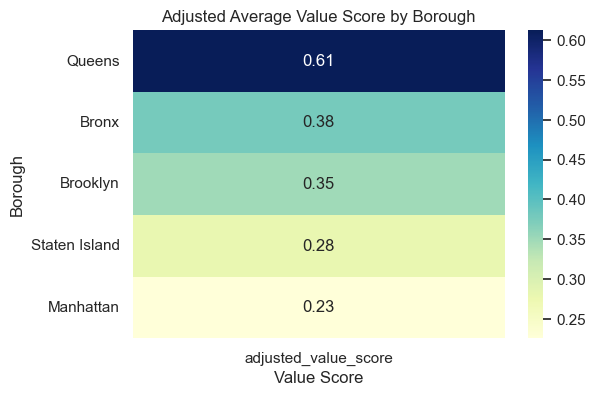

In [64]:
plt.figure(figsize=(6,4))
sns.heatmap(
    borough_summary[["adjusted_value_score"]],
    annot=True,
    fmt=".2f",
    cmap="YlGnBu"
)
plt.title("Adjusted Average Value Score by Borough")
plt.xlabel("Value Score")
plt.ylabel("Borough")
plt.show()


Price vs Availability Scatter Plot

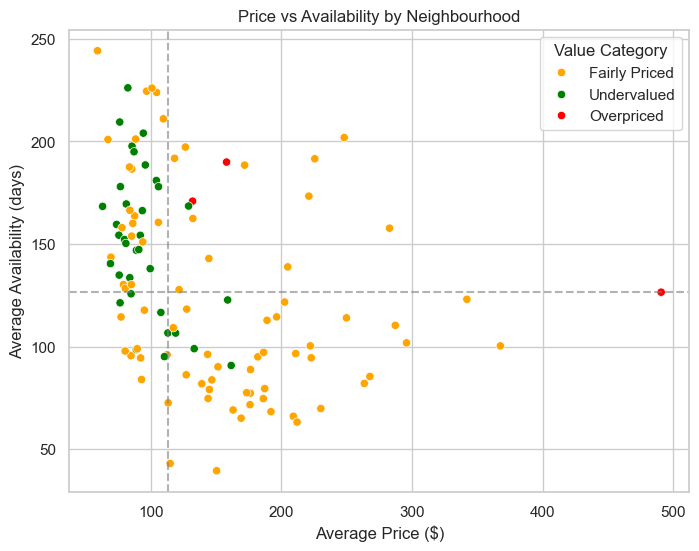

In [69]:
plt.figure(figsize=(8,6))

sns.scatterplot(
    data=filtered_features,
    x="avg_price",
    y="avg_availability",
    hue="value_category",
    palette={
        "Undervalued": "green",
        "Fairly Priced": "orange",
        "Overpriced": "red"
    }
)
plt.axvline(
    filtered_features["avg_price"].median(),
    linestyle="--",
    color="grey",
    alpha=0.6
)
plt.axhline(
    filtered_features["avg_availability"].median(),
    linestyle="--",
    color="grey",
    alpha=0.6
)

plt.title("Price vs Availability by Neighbourhood")
plt.xlabel("Average Price ($)")
plt.ylabel("Average Availability (days)")
plt.legend(title="Value Category")
plt.show()


Top 10 Undervalued Neighbourhoods

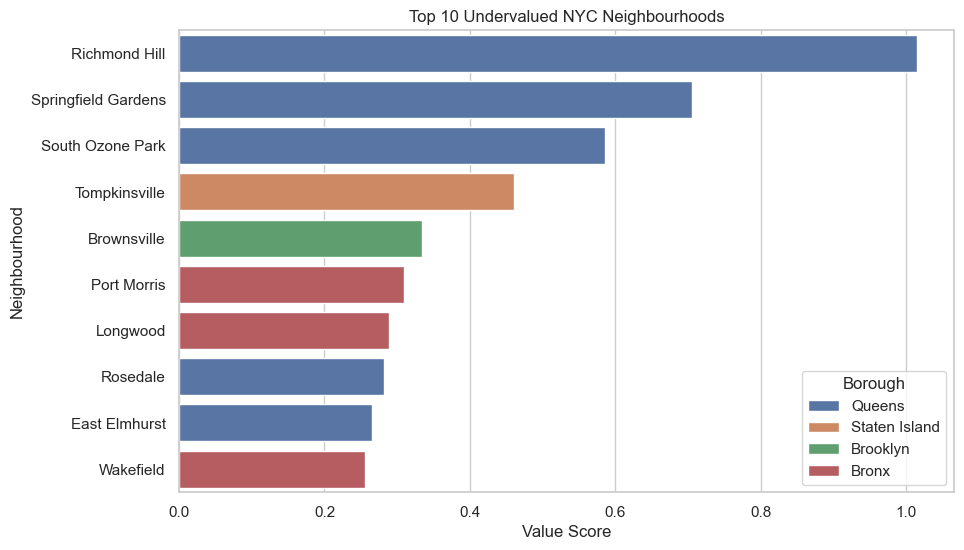

In [66]:
top_10_undervalued = filtered_features[
    filtered_features["value_category"] == "Undervalued"
].sort_values("value_score", ascending=False).head(10)

plt.figure(figsize=(10,6))

sns.barplot(
    data=top_10_undervalued,
    x="value_score",
    y="neighbourhood",
    hue="neighbourhood_group",
    dodge=False
)

plt.title("Top 10 Undervalued NYC Neighbourhoods")
plt.xlabel("Value Score")
plt.ylabel("Neighbourhood")
plt.legend(title="Borough")
plt.show()


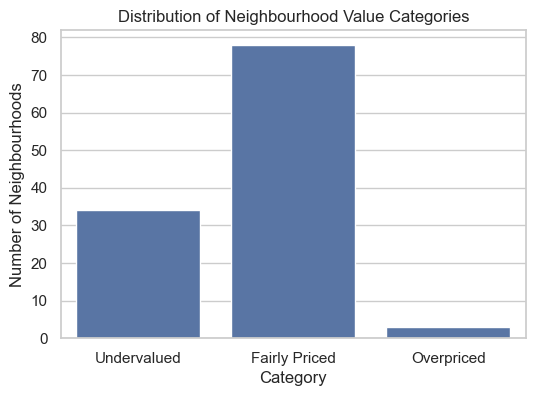

In [67]:
plt.figure(figsize=(6,4))

sns.countplot(
    data=filtered_features,
    x="value_category",
    order=["Undervalued", "Fairly Priced", "Overpriced"]
)

plt.title("Distribution of Neighbourhood Value Categories")
plt.xlabel("Category")
plt.ylabel("Number of Neighbourhoods")
plt.show()


C:\Users\Surya\AppData\Local\Temp\ipykernel_2752\1264050448.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  borough_summary["mean_price"][i],
C:\Users\Surya\AppData\Local\Temp\ipykernel_2752\1264050448.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  borough_summary["adjusted_value_score"][i],


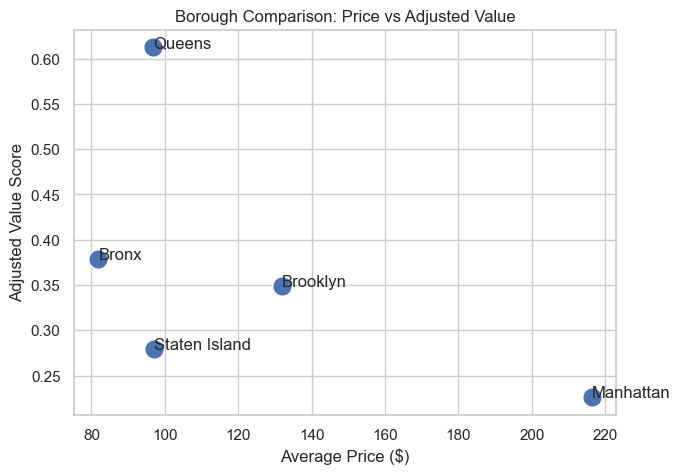

In [68]:
plt.figure(figsize=(7,5))

sns.scatterplot(
    data=borough_summary,
    x="mean_price",
    y="adjusted_value_score",
    s=200
)

for i in range(len(borough_summary)):
    plt.text(
        borough_summary["mean_price"][i],
        borough_summary["adjusted_value_score"][i],
        borough_summary.index[i]
    )

plt.title("Borough Comparison: Price vs Adjusted Value")
plt.xlabel("Average Price ($)")
plt.ylabel("Adjusted Value Score")
plt.show()


Folium

In [70]:
# Aggregate latitude & longitude per neighbourhood
location_data = (
    df.groupby(["neighbourhood_group", "neighbourhood"])
    .agg(
        latitude=("latitude", "mean"),
        longitude=("longitude", "mean")
    )
    .reset_index()
)

# Merge with filtered features
map_data = filtered_features.merge(
    location_data,
    on=["neighbourhood_group", "neighbourhood"],
    how="left"
)

map_data.head()


,neighbourhood_group,neighbourhood,avg_price,avg_availability,avg_reviews,popularity_score,listing_count,log_avg_price,log_popularity,price_norm,availability_norm,popularity_norm,value_score,value_category,value_rank,justification,latitude,longitude
0,Bronx,Allerton,87.595238,163.666667,42.928571,1.534377,42,4.484078,0.929948,0.053492,0.448402,0.033927,0.099111,Fairly Priced,47.0,higher availability,40.865292,-73.858727
1,Bronx,Concourse,86.180000,160.040000,32.860000,0.900326,50,4.467975,0.642026,0.051612,0.438466,0.019907,0.057572,Fairly Priced,80.0,balanced across metrics,40.826919,-73.924469
2,Bronx,Concourse Village,73.781250,159.531250,25.218750,2.318207,32,4.314567,1.199425,0.035139,0.437072,0.051258,0.165781,Undervalued,17.0,"lower-than-average price, strong demand",40.830054,-73.917805
3,Bronx,Fordham,69.444444,143.555556,15.174603,0.640018,63,4.254824,0.494707,0.029377,0.393303,0.014151,0.043020,Fairly Priced,96.0,lower-than-average price,40.863222,-73.894359
4,Bronx,Kingsbridge,77.928571,157.942857,20.500000,1.397012,70,4.368543,0.874223,0.040649,0.432720,0.030889,0.095034,Fairly Priced,50.0,lower-than-average price,40.876798,-73.901789


In [84]:
import folium

nyc_map = folium.Map(
    location=[40.7128, -74.0060],
    zoom_start=11,
    tiles="CartoDB positron"
)


In [85]:
def get_color(category):
    return {
        "Undervalued": "#2ECC71",     # green
        "Fairly Priced": "#F1C40F",   # yellow
        "Overpriced": "#E74C3C"       # red
    }.get(category, "#95A5A6")


In [86]:
nyc_map = folium.Map(
    location=[40.7128, -74.0060],
    zoom_start=11,
    tiles="CartoDB Positron",
    control_scale=True
)


In [87]:
# Normalize value score for marker size
min_score = map_data["value_score"].min()
max_score = map_data["value_score"].max()

def scale_radius(score, min_r=5, max_r=12):
    return min_r + (score - min_score) / (max_score - min_score) * (max_r - min_r)


In [88]:
def make_tooltip(row):
    return f"""
    <div style="font-size:13px">
    <b>{row['neighbourhood']}</b> ({row['neighbourhood_group']})<br>
    🔖 <b>Status:</b> {row['value_category']}<br>
    ⭐ <b>Value Score:</b> {row['value_score']:.2f}<br>
    💲 <b>Avg Price:</b> ${row['avg_price']:.0f}<br>
    📅 <b>Availability:</b> {row['avg_availability']:.0f} days
    </div>
    """


In [89]:
for _, row in map_data.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=scale_radius(row["value_score"]),
        color=get_color(row["value_category"]),
        fill=True,
        fill_color=get_color(row["value_category"]),
        fill_opacity=0.75,
        weight=1,
        tooltip=folium.Tooltip(
            make_tooltip(row),
            sticky=True
        ),
        popup=folium.Popup(
            f"""
            <div style="font-size:13px">
            <b>{row['neighbourhood']}</b><br>
            <i>{row['neighbourhood_group']}</i><hr style="margin:4px 0">
            💲 <b>Price:</b> ${row['avg_price']:.0f}<br>
            📅 <b>Availability:</b> {row['avg_availability']:.0f} days<br>
            ⭐ <b>Value Score:</b> {row['value_score']:.2f}<br>
            🔖 <b>Status:</b> {row['value_category']}
            </div>
            """,
            max_width=280
        )
    ).add_to(nyc_map)


In [90]:
legend_html = """
<div style="
    position: fixed;
    bottom: 30px;
    left: 30px;
    width: 190px;
    background-color: white;
    border-radius: 8px;
    padding: 10px;
    font-size: 14px;
    box-shadow: 2px 2px 8px rgba(0,0,0,0.3);
    z-index:9999;
">
<b>NYC Airbnb Value</b><br>
<hr style="margin:4px 0">
<span style="color:#2ECC71;">●</span> Undervalued<br>
<span style="color:#F1C40F;">●</span> Fairly Priced<br>
<span style="color:#E74C3C;">●</span> Overpriced
</div>
"""

nyc_map.get_root().html.add_child(folium.Element(legend_html))


In [91]:
nyc_map.save("../data/nyc_airbnb_value_map_polished.html")


Plotly

In [83]:
import plotly.express as px

fig = px.scatter_mapbox(
    map_data,
    lat="latitude",
    lon="longitude",
    color="value_category",
    size="value_score",
    hover_name="neighbourhood",
    hover_data={
        "avg_price": ":.2f",
        "avg_availability": ":.1f",
        "value_score": ":.2f"
    },
    zoom=10,
    height=600,
    mapbox_style="carto-positron",
    title="NYC Airbnb Neighbourhood Value Map"
)

fig.show()


C:\Users\Surya\AppData\Local\Temp\ipykernel_2752\2772729425.py:3: DeprecationWarning: *scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/
  fig = px.scatter_mapbox(
